In [1]:
%pylab inline
import os 
import sys
from tqdm import trange

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np 
import requests
fp = "C:\tmp"
def fetch(url):
    import requests, gzip
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
              file = f.read()
    else:
        with gzip.open(r'fp','wb') as f:
            file = requests.get(url).content
            f.write(file)
    return np.frombuffer(gzip.decompress(file), dtype = np.uint8)
x_train = fetch('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')[16:].reshape(60000,28,28)
y_train = fetch('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')[8:]
x_test = fetch('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')[16:].reshape(-1,28,28)
y_test = fetch('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')[8:]

In [21]:

import torch 
import torch.nn as nn
import torch.nn.functional as F
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv2d(1,32,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(7 * 7 * 64, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.dropout = torch.nn.Dropout(p=0.5)
        
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.max_pool2d(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool2d(x)
        x = x.reshape(x.shape[0],-1)
        x = self.linear_1(x)
        x = self.dropout(x)
        return self.linear_2(x)
        
        

In [31]:
model = ConvNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = torch.nn.CrossEntropyLoss()

loss 0.03 accuracy 0.99: 100%|█████████████████████████████████████████████████████| 1000/1000 [01:12<00:00, 13.80it/s]


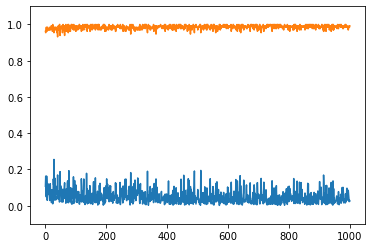

In [36]:
BS = 132
losses , acc = [],[]
for i in(t := trange(1000)):
    rand = np.random.randint(0, x_train.shape[0], size=(BS))
    X =torch.tensor(x_train[rand]).unsqueeze(1).float()
    Y = torch.tensor(y_train[rand]).long()
    optimizer.zero_grad()
    out = model(X)
    cat = torch.argmax(out,dim=1)
    accuracy = (cat == Y).float().mean()
    loss = loss_func(out, Y)
    loss = loss.mean()
    loss.backward()
    optimizer.step()
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    acc.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))

plt.ylim(-0.1, 1.1)
plot(losses)
plot(acc)    

In [37]:
Y_test_preds = torch.argmax(model(torch.tensor(x_test).unsqueeze(1).float()),dim=1).numpy()
(y_test == Y_test_preds).mean()

0.9817